<a href="http://landlab.github.io"><img style="float: left"
src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>

# Animate Landlab output
<hr>

<p><small>How to use IPython notebooks:
<a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small></p>

<p><small>More Landlab tutorials:
<a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small></p>

<hr>

## Introduction
This tutorial presents a workflow to animate model output. The workflow is presented in two phases of a Landlab model.

This workflow requires software that might not be installed on your computer. The required software is open-source and freely available for Linux, MacOS, and Windows.
* Phase 1: A mp4 video format is produced using FFMpeg (https://www.ffmpeg.org/download.html).
* Phase 2: A gif video format is produced using ImageMagick (https://www.imagemagick.org/script/download.php).

This software can also be installed using some package managers.

## Prepare the model for both phases

#### Import the modules called by this tutorial.

In [1]:
from landlab import RasterModelGrid
from landlab.components import FastscapeEroder, FlowRouter
from landlab.plot import channel_profile, imshow_grid
import matplotlib.animation as animation
import matplotlib.pylab as plt
import numpy as np

#### Create a grid, set boundary conditions, and initialize components.

In [2]:
mg = RasterModelGrid((40, 40), 100)
z = mg.add_zeros('node','topographic__elevation')
z += np.random.rand(z.size)

outlet_id = int(mg.number_of_node_columns * 0.5)
mg.set_watershed_boundary_condition_outlet_id(outlet_id, z)
mg.at_node['topographic__elevation'][outlet_id] = 0

fr = FlowRouter(mg)
sp = FastscapeEroder(mg, K_sp=3e-5, m_sp=0.5, n_sp=1)

#### Set model time and uplift parameters.

In [3]:
simulation_duration = 1e6
dt = 1000
n_timesteps = int(simulation_duration // dt) + 1
timesteps = np.linspace(0, simulation_duration, n_timesteps,
                        endpoint=True)

uplift_rate = 0.001
uplift_per_timestep = uplift_rate * dt

## Phase 1: Animate elevation change using imshow_grid
#### Animate simulated topography as it tends toward steady state.

Before model timesteps are run, we prepare the animation:
* create a matplotlib figure
* initiate an animation writer using the matplotlib module, `animation`
* use `FFMpegWriter` to create a mp4 movie
* set up to animate 6 frames per second (fps)
* prepare the animation writer with the function, `setup`
* set the output movie file name to 'first_phase.mp4'

In [4]:
fig = plt.figure()
writer = animation.FFMpegWriter(fps=6)
writer.setup(fig, 'first_phase.mp4')

#### Capture the figure to animate at timesteps.

The method, `writer.grab_frame` captures the state of `fig` at designated timesteps. 

In [5]:
for t in timesteps:

    # Capture an animation frame every 50,000 years.
    if t % 5e4 == 0:
        imshow_grid(mg, z, colorbar_label='elevation (m)')
        plt.title('{:.0f} kiloyears'.format(t * 1e-3),
                  fontsize=14) 

        writer.grab_frame()

        # Remove the colorbar to reset the figure for the next animation timestep.
        plt.gci().colorbar.remove()

    # Uplift and erode.
    z[mg.core_nodes] += uplift_per_timestep
    fr.run_one_step()
    sp.run_one_step(dt)

#### Finish the animation.

The method, `writer.finish` completes the processing of the movie and saves then it.

In [6]:
writer.finish()

This code loads the saved mp4 and presents it in a browser in an IPython session.

In [7]:
from IPython.display import HTML

HTML("""<div align="middle"> <video width="80%" controls loop>
     <source src="first_phase.mp4" type="video/mp4"> </video></div>""")

## Phase 2: Animate visualizations of elevation change in subplots
Uplift rate is increased instantaineously prior to running the second phase of the model.

In [8]:
increased_uplift_per_timestep = 10 * uplift_per_timestep

#### Define a plotting function.

The function, `plot_hypsometry` plots normalized drainage area versus normalized elevation of a channel. The channel nodes are identified using the `channel_profile` Landlab tool.

In [9]:
def plot_hypsometry(fig_axes, grid, initial=False):
    at_node = grid.at_node
    A = at_node['drainage_area']
    chan_nodes = channel_profile.channel_nodes(
        grid,
        at_node['topographic__steepest_slope'],
        A, at_node['flow__receiver_node'])
    
    # Normalize parameters.
    A_pro = A[chan_nodes]
    A_norm = (A_pro - A_pro.min()) / (A_pro.max() - A_pro.min())
    z_pro = z[chan_nodes]
    z_norm = (z_pro - z_pro.min()) / (z_pro.max() - z_pro.min())

    if initial:
        color = 'r:'
        label = 'initial'
    else:
        color = 'k'
        label = 'current timestep'
    fig_axes.plot(A_norm, z_norm, color, label=label)
    fig_axes.set_xlabel('relative area (a/A)')
    fig_axes.set_ylabel('relative height (h/H)')
    
    return fig_axes.lines

#### Set up a figure with two subplots.

`axes[0]` and `axes[1]` refer to the first and second subplot, respectively.

In [10]:
fig2, axes = plt.subplots(1, 2, figsize=(12, 5))    
fig2.subplots_adjust(wspace=0.3, top=0.85)
axes[0].set_title('topography')
axes[1].set_title('hypsometry')

Text(0.5,1,'hypsometry')

#### Set up a movie file.

A gif formatted movie is created in this model phase using the software, ImageMagick.

In [11]:
writer = animation.ImageMagickWriter(fps=6)
writer.setup(fig2, 'second_phase.gif')

#### Plot the hypsometry baseline.

The initial hyposometry is kept on the second subplot to help visualize how hyposometry has changed during the simulation.

In [12]:
_ = plot_hypsometry(axes[1], mg, initial=True)

#### Capture the figure to animate at timesteps.

The simulation is ran for another 1,000,000 years.

In [13]:
for t in timesteps:
 
    # Capture an animation frame every 50,000 years.
    if t % 5e4 == 0:
        fig2.sca(axes[0])
        imshow_grid(mg, z, colorbar_label='elevation (m)')
        colorbar = plt.gci().colorbar

        hysometric_line = plot_hypsometry(axes[1], mg)

        fig2.suptitle('{:.0f} kiloyears'.format(t * 1e-3),
                 fontsize=14)  

        # Add the legend to the second subplot only once.
        if t == 0: 
            _ = axes[1].legend()
            
        writer.grab_frame()

        # Reset the figure for the next animation timestep.
        colorbar.remove()        
        del hysometric_line[-1]

    # Uplift and erode.
    z[mg.core_nodes] += increased_uplift_per_timestep
    fr.run_one_step()
    sp.run_one_step(dt)
    
writer.finish()

This code loads the saved gif and presents it in a browser in an IPython session.

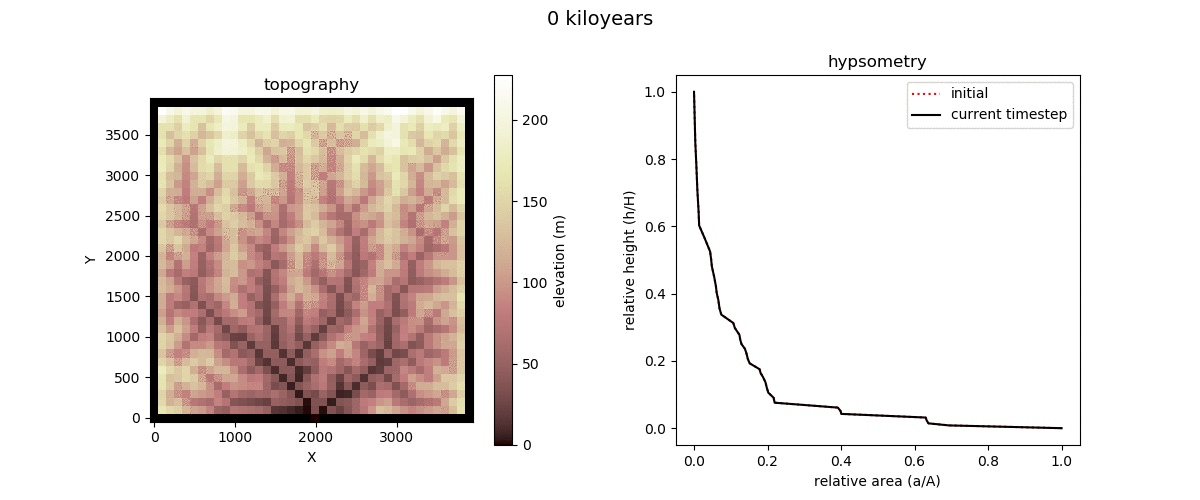

In [14]:
from IPython.display import Image
Image(filename='second_phase.gif') 

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>